# Stable Diffusion一MNIST


In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([9, 3, 5, 0, 3, 5, 4, 4])


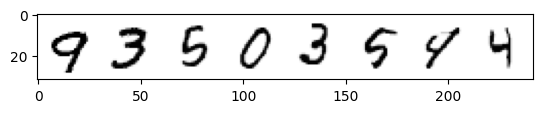

In [2]:
dataset = torchvision.datasets.MNIST(root=".", train=True, download=True, transform=torchvision.transforms.ToTensor())
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

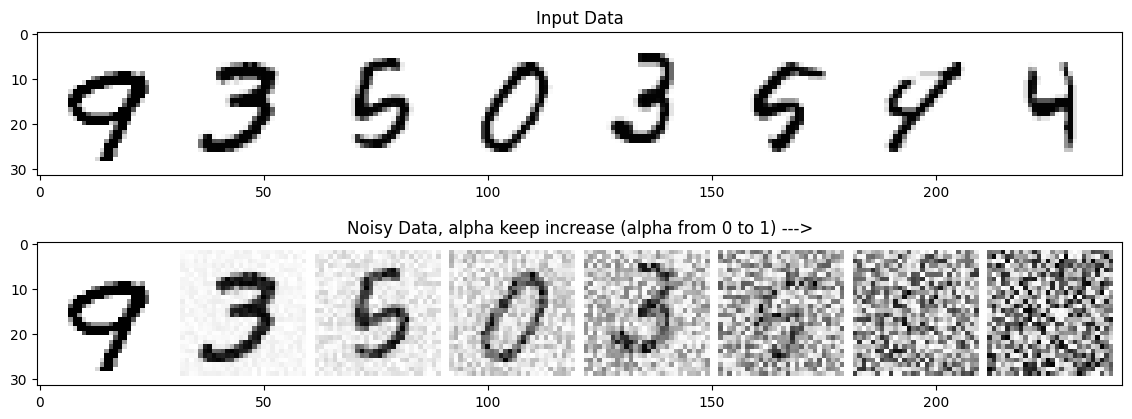

In [3]:
def noislization(x, alpha):
  """ input `x` by mixing it with noise according to `alpha`"""
  noise = torch.rand_like(x)
  alpha = alpha.view(-1, 1, 1, 1) # Sort shape so broadcasting works
  return x*(1-alpha) + noise*alpha 

fig, axs = plt.subplots(2, 1, figsize=(14, 5))
axs[0].set_title('Input Data')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

# add noise
alpha = torch.linspace(0, 1, x.shape[0])
noisy_x = noislization(x, alpha)

# 新圖像
axs[1].set_title('Noisy Data, alpha keep increase (alpha from 0 to 1) --->')
axs[1].imshow(torchvision.utils.make_grid(noisy_x)[0], cmap='Greys')

In [4]:
class ConvM(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        norm_layer = nn.BatchNorm2d
        super(ConvM, self).__init__(
            nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=False),
            norm_layer(out_planes),
            nn.SiLU(),
        )

class UNet_simple(nn.Module):
    def __init__(self, in_channels = 1, out_channels = 1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([
            ConvM(in_channels, 32, 3, 1),
            ConvM(32, 64, 3, 1),
            ConvM(64, 64, 3, 1)
        ]) 

        self.up_layers = torch.nn.ModuleList([
            ConvM(64, 64, 3, 1),
            ConvM(64, 32, 3, 1),
            nn.Conv2d(32, out_channels, kernel_size=3, padding=1, bias=True)
        ])
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = l(x)
            if i < 2: 
                h.append(x) 
                x = self.downscale(x) 
        for i, l in enumerate(self.up_layers):
            if i > 0: 
                x = self.upscale(x)
                x += h.pop() 
            x = l(x)
        x = self.sigmoid(x)
        return x
    
unet = UNet_simple()
x  = torch.rand(8, 1, 28, 28)
print('mdoel output size:{}'.format(unet(x).shape))

t = 0
for p in unet.parameters():
    t += p.numel()
print('total number of parameter: {}'.format(t))

mdoel output size:torch.Size([8, 1, 28, 28])
total number of parameter: 111681


In [5]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, stride=1, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.triple_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, mid_channels, kernel_size=3, stride = 1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.triple_conv(x)

    
class mytinyUNet(nn.Module):
    def __init__(self, in_channels = 1, out_channels = 1):
        super(mytinyUNet, self).__init__()
    
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.inc = DoubleConv(in_channels, 64)
        self.down1 = DoubleConv(64, 64,stride=2)
        self.down2 = DoubleConv(64, 128,stride=2)
        
        self.up1 = DoubleConv(128, 64)
        self.up2 = DoubleConv(128, 64)

        self.outfusion = DoubleConv(128, 64)
        self.outc = nn.Conv2d(64, out_channels, kernel_size=3, stride=1, padding=1)


    def forward(self, x):
        x1 = self.inc(x) # 1*28*28→ 64*28*28
        x2 = self.down1(x1) # 64*28*28 → 64*14*14
        x3 = self.down2(x2) # 64*14*14→ 128*7*7
        
        x3 = self.up(x3) # 128*7*7 → 128*14*14
        x = self.up1(x3) # 128*14*14 → 64*14*14
        x = torch.cat([x2, x], dim=1) # (64+64)*14*14
                
        x = self.up(x) # 128*14*14 → 128*28*28
        x = self.up2(x) # 128*28*28 → 64*28*28
        x = torch.cat([x1, x], dim=1) # (64+64)*28*28
        
        x = self.outfusion(x) # 128*28*28 → 64*28*28
        logits = self.outc(x) # 64*28*28 → 1*28*28
        return logits

model = mytinyUNet(in_channels=1, out_channels=1)    
x  = torch.rand(8, 1, 28, 28)
print('mdoel output size:{}'.format(model(x).shape))

t = 0
for p in unet.parameters():
    t += p.numel()
print('total number of parameter: {}'.format(t))

mdoel output size:torch.Size([8, 1, 28, 28])
total number of parameter: 111681


In [6]:
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# run 3 times
n_epochs = 3

# Create the network
model = UNet_simple(in_channels=1, out_channels=1)
model.to(device)
model2 = mytinyUNet(in_channels=1, out_channels=1)    
model2.to(device)

# optim
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
opt2 = torch.optim.Adam(model2.parameters(), lr=1e-3)

# loss function
loss_fn = nn.MSELoss()

# loss
losses, losses2 = [], []
model.train()
model2.train()
for epoch in range(n_epochs):
    for i, (x, y) in enumerate(train_dataloader):
        x = x.to(device)
        noise_alpha = torch.rand(x.shape[0]).to(device)
        noisy_x = noislization(x, noise_alpha)
        
        # pred
        pred = model(noisy_x)
        loss = loss_fn(pred, x)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())

        pred = model2(noisy_x)
        loss = loss_fn(pred, x)
        opt2.zero_grad()
        loss.backward()
        opt2.step()
        losses2.append(loss.item())


    total_loss = 0
    for loss in losses[-len(train_dataloader):]:
        total_loss += loss
    avg_loss = total_loss / len(train_dataloader)

    total_loss = 0
    for loss in losses2[-len(train_dataloader):]:
        total_loss += loss
    avg_loss2 = total_loss / len(train_dataloader)
    print(f'Epoch {epoch+1}, Loss1: {avg_loss:.4f}, Loss2: {avg_loss2:.4f}')



Epoch 1, Loss1: 0.0206, Loss2: 0.0201
Epoch 2, Loss1: 0.0148, Loss2: 0.0143
Epoch 3, Loss1: 0.0138, Loss2: 0.0132


(0.0, 0.2)

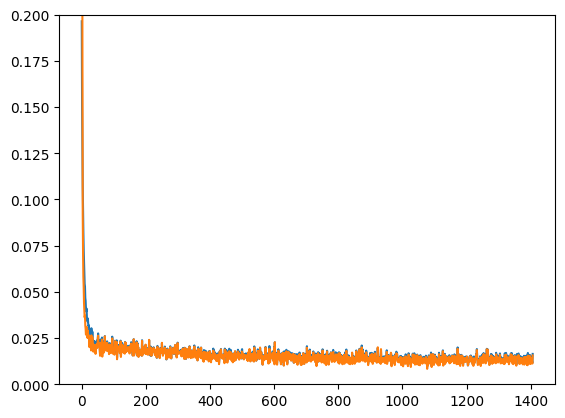

In [7]:
plt.plot(losses)
plt.plot(losses2)
plt.ylim(0, 0.2)

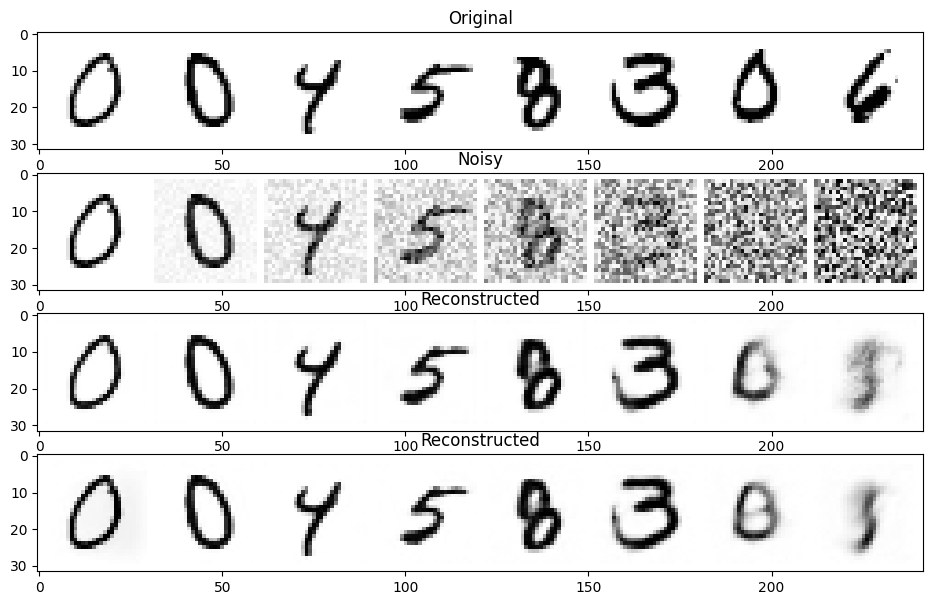

In [8]:
# Fetch some data
x, y = next(iter(train_dataloader))
x = x[:8] # only first 8 images

alpha = torch.linspace(0, 1, x.shape[0])
noised_x = noislization(x, alpha)

with torch.no_grad():
    pred = model(noised_x.to(device)).detach().cpu()
    pred2 = model2(noised_x.to(device)).detach().cpu()

# plot
fig, axs = plt.subplots(4, 1, figsize=(12, 7))
axs[0].set_title('Original')
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap='Greys')

axs[1].set_title('Noisy')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap='Greys')

axs[2].set_title('Reconstructed')
axs[2].imshow(torchvision.utils.make_grid(pred)[0].clip(0, 1), cmap='Greys')

axs[3].set_title('Reconstructed')
axs[3].imshow(torchvision.utils.make_grid(pred2)[0].clip(0, 1), cmap='Greys')

# Inference 


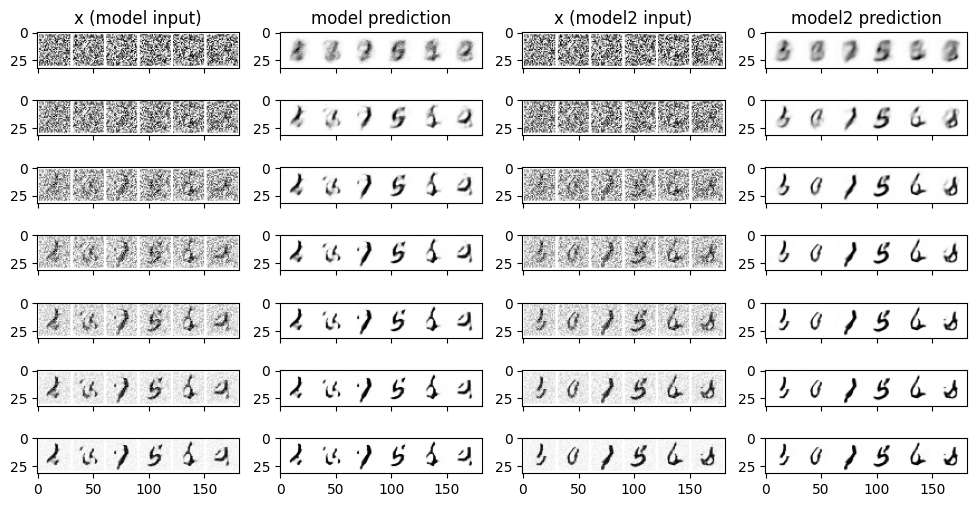

In [9]:
n_steps = 7
batch = 6
x = torch.rand(batch, 1, 28, 28).to(device) # Start from random
x2 = x
step_history = [x.detach().cpu()]
step_history2 = [x2.detach().cpu()]
pred_output_history = []
pred_output_history2 = []
model.eval()
model2.eval()
for i in range(n_steps):
    with torch.no_grad(): # No need to track gradients during inference
        pred = model(x) # Predict the denoised x0
        pred2 = model2(x2) # Predict the denoised x0
    pred_output_history.append(pred.detach().cpu()) # Store model output for plotting
    pred_output_history2.append(pred2.detach().cpu()) # Store model output for plotting
    mix_factor = 1/(n_steps - i) # How much we move towards the prediction
    x = x*(1-mix_factor) + pred*mix_factor # Move part of the way there
    x2 = x2*(1-mix_factor) + pred2*mix_factor # Move part of the way there
    step_history.append(x.detach().cpu()) # Store step for plotting
    step_history2.append(x2.detach().cpu()) # Store step for plotting

fig, axs = plt.subplots(n_steps, 4, figsize=(batch*2, batch), sharex=True)
axs[0,0].set_title('x (model input)')
axs[0,1].set_title('model prediction')

axs[0,2].set_title('x (model2 input)')
axs[0,3].set_title('model2 prediction')
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap='Greys')
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap='Greys')

    axs[i, 2].imshow(torchvision.utils.make_grid(step_history2[i])[0].clip(0, 1), cmap='Greys')
    axs[i, 3].imshow(torchvision.utils.make_grid(pred_output_history2[i])[0].clip(0, 1), cmap='Greys')